# Slice Timing Correction

-------

# Algorithm

## Pseudocode

**Description:** Corrects sampling offsets that occur during fMRI acquisition. "Slice timing correction corrects each voxel's time-series for the fact that later processing assumes that all slices were acquired exactly half-way through the relevant volume's acquisition time (TR), whereas in fact each slice is taken at slightly different times. Slice timing correction works by using (Hanning-windowed) sinc interpolation to shift each time-series by an appropriate fraction of a TR relative to the middle of the TR period. It is necessary to know in what order the slices were acquired and set the appropriate option here. If slices were acquired from the bottom of the brain to the top select Regular up. If slices were acquired from the top of the brain to the bottom select Regular down. If the slices were acquired with interleaved order (0, 2, 4 ... 1, 3, 5 ...) then choose the Interleaved option." A TR of 0 corresponds to no shift. **Source:** [FSL User Guide](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT/UserGuide)

**Inputs:** 
  1. mri, the 4D (fMRI) image volume as a nifti filepath
  2. corrected_mri, the output filepath of the corrected and aligned fMRI image volume
  3. stc, the slice timing correction options:
      * "/path/to/file", text file such that each line corresponds to a single value (in TRs) of the shift of each slice
      * "down", indicates slices were acquired from the top down
      * "up", indicates slices were acquired from the bottom up
      * "interleaved", indicates slices were aquired one parity (even/odd) at a time
      
**Outputs:** Slice-timing corrected 4d (fMRI) image volume saved at given output path

**Algorithm:**
Slice timing correction uses the following formula for the Hann-windowed sinc interpolation:

$\hat{h}_{\Delta}(n)=\begin{cases}\omega(n-\Delta)sinc[\alpha(n-\Delta)],&0\leq n\leq N-1\\0,&otherwise\end{cases}$

where $\omega(n)=0.5\left(1-cos\left(\frac{2\pi n}{N-1}\right)\right)$ is the Hann window and $\alpha$ describes the transition width.


## Performance & Analysis

The slice-timing correction algorithm should generally perform well for short TR times (less than 2 seconds), because under this condition, the data will not be changed to a significant degree. It has the potential to perform poorly for larger TR times and when used before motion correction since it can lead to the propagation of artifacts.

To qualitatively visualize the effects of slice timing correction, we can view plots of the same hemodynamic response with respect to time across several slices before and after the correction. After the correction, the plots should overlap each other more closely. Quantitatively, slice timing correction should increase the discriminability between intra- and inter-subject scans. For the simulations, it should decrease the mean squared error between the actual data and the test data.

## Raw Data

For the good performance, we will test the slice timing correction algorithm on several different interleaved ascending datasets: BNU_1, BNU_2, and DC_1. The [BNU_1](http://neurodatadesign.github.io/fngs/ewok_weekly/stc/BNU_1_scantable.pdf) dataset has a TR of 2000 ms (2.0 sec). The data consists of 57 subjects, each of whom have 2 scans. Each of the 4D scans have the following dimensions: 64 x 64 x 33 brain at 200 timesteps.

<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/BNU1.png">

The BNU_2 dataset has a TR of 2000 ms (2.0 sec) for the [baseline](http://neurodatadesign.github.io/fngs/ewok_weekly/stc/BNU_2_Test_scantable.pdf) scans and a TR of 1500 ms (1.5 sec) for the [retest](http://neurodatadesign.github.io/fngs/ewok_weekly/stc/BNU_2_Retest_scantable.pdf) scans. The data consists of 61 subjects, each of whom have 2 scans. Each of the 4D baseline/retest scans have the following dimensions: 64 x 64 x 33/25 brain at 240/420 timesteps.

<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/BNU2.png">

The [DC_1](http://neurodatadesign.github.io/fngs/ewok_weekly/stc/DC_1_scantable.pdf) dataset has a TR of 2500 ms (2.5 sec). The data consists of 114 subjects, each of whom have 2-4 scans. Each of the 4D scans have the following dimensions: 80 x 80 x 36 brain at 120 timesteps.

<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/DC1.png">

For the poor performance, we will test the slice timing correction algorithm on the [LMU_1](http://neurodatadesign.github.io/fngs/ewok_weekly/stc/LMU_1_scantable.pdf) dataset, which was aquired in a sequential ascending manner. The LMU_1 dataset has a TR of 2500 ms (2.5 sec). The data consists of 27 subjects, each of whom have 6 scans. Each of the 4D scans have the following dimensions: 80 x 80 x 36 brain at 120 timesteps.

<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/LMU1.png">

I expect that the algorithm will run well on the interleaved datasets, but not as well on the sequientially aquired dataset. Longer TR times may also present an effect on the change in discriminability. The discriminability should increase by more for those datasets with shorter TR times.

# Simulation

For the following simulations, we will use three sine waves that are offset temporally to represent three scans acquired at slightly different times. We will then run the slice timing correction algorithm on the generated data assuming a sequential acquisition method. For the good performance, with no noise and short TR time (1.5 seconds), the sine waves should almost completely overlap. For the bad performance, with noise applied to the middle sine wave to simulate pre-motion-corrected data and a longer TR time (3 seconds), the sine waves should not move as close to each other. Quantitatively, the mean squared error should decrease significantly for the good performance, while it should decrease only slightly for the poor performance.

## Good performance

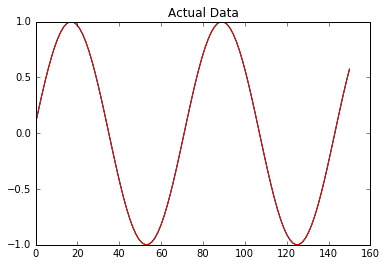

In [64]:
%matplotlib inline
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
t = np.linspace(0,150,101)
actual = np.zeros((3,1,1,101))
for i in range(0,3):
    actual[i,0,0,] = np.sin(2*np.pi*(t+1)/360*5)
plt.title("Actual Data")
plt.plot(t, actual[0,0,0,], t, actual[1,0,0,], t, actual[2,0,0,]);
testdat = np.zeros((3,1,1,101))
testdat[0,0,0,] = np.sin(2*np.pi*t/360*5)
testdat[1,0,0,] = np.sin(2*np.pi*(t+1)/360*5)
testdat[2,0,0,] = np.sin(2*np.pi*(t+2)/360*5)
im2 = nb.load('./data/BNU_2_0025921_2_rest.nii.gz') # used for header
im = nb.Nifti1Image(testdat, header=im2.header, affine=im2.affine)
nb.save(im, './data/sim1500.nii.gz')

From here, we type the following in the command line:  
fsl5.0-slicetimer -i './data/sim1500.nii.gz' -o './data/sim1500_st.nii.gz' -r 1.5 -d 1

Before and After Slice Timing Correction


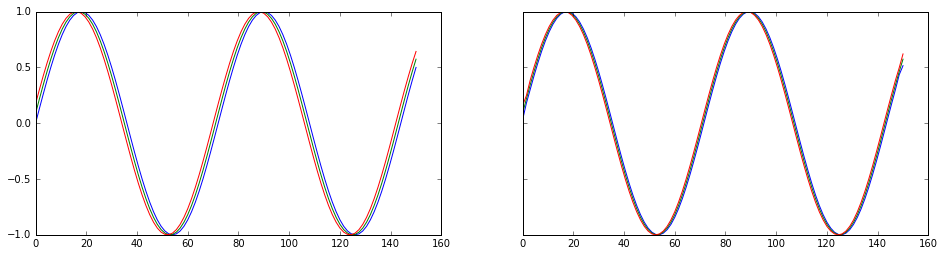

In [65]:
st = nb.load('./data/sim1500_st.nii.gz')
dat = st.get_data()
print("Before and After Slice Timing Correction")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
axes = plt.gca()
axes.set_ylim([-1,1])
ax1.plot(t, testdat[0,0,0,], t, testdat[1,0,0,], t, testdat[2,0,0,]);
ax2.plot(t, dat[0,0,0,], t, dat[1,0,0,], t, dat[2,0,0,]);
f.set_size_inches(16, 4)

Qualitatively, we can see that the three slices are closer together after slice timing correction has occurred. Next, we will evaluate the performance quantitatively. We will see that the slice timing correction significantly lowers the mean squared error.

In [66]:
mse_sim = ((actual - testdat) ** 2).mean(axis=None)
mse_sim_st = ((actual - dat) ** 2).mean(axis=None)
print("Mean squared error pre-STC:  " + str(mse_sim))
print("Mean squared error post-STC: " + str(mse_sim_st))

Mean squared error pre-STC:  0.00262626518437
Mean squared error post-STC: 0.000674445780238


## Poor performance

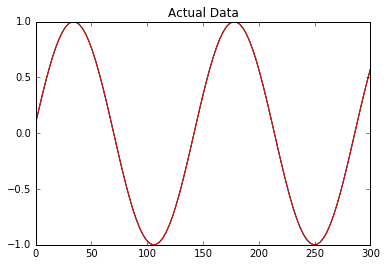

In [67]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
t = np.linspace(0,300,101)
actual = np.zeros((3,1,1,101))
for i in range(0,3):
    actual[i,0,0,] = np.sin(2*np.pi*(t+2)/360*2.5)
plt.title("Actual Data")
plt.plot(t, actual[0,0,0,], t, actual[1,0,0,], t, actual[2,0,0,]);
testdat = np.zeros((3,1,1,101))
testdat[0,0,0,] = np.sin(2*np.pi*t/360*2.5)
testdat[1,0,0,] = np.sin(2*np.pi*(t+2)/360*2.5) + np.random.normal(0, 0.125, 101)
testdat[2,0,0,] = np.sin(2*np.pi*(t+4)/360*2.5)
im2 = nb.load('./data/BNU_2_0025921_2_rest.nii.gz') # used for header
im = nb.Nifti1Image(testdat, header=im2.header, affine=im2.affine)
nb.save(im, './data/sim3000.nii.gz')

From here, we type the following in the command line:  
fsl5.0-slicetimer -i './data/sim3000.nii.gz' -o './data/sim3000_st.nii.gz' -r 3 -d 1

Before and After Slice Timing Correction


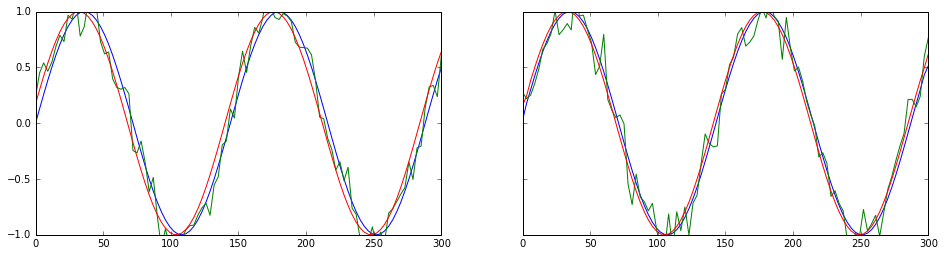

In [77]:
st = nb.load('./data/sim3000_st.nii.gz')
dat = st.get_data()
print("Before and After Slice Timing Correction")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
axes = plt.gca()
axes.set_ylim([-1,1])
ax1.plot(t, testdat[0,0,0,], t, testdat[1,0,0,], t, testdat[2,0,0,]);
ax2.plot(t, dat[0,0,0,], t, dat[1,0,0,], t, dat[2,0,0,]);
f.set_size_inches(16, 4)

In [75]:
mse_sim = ((actual - testdat) ** 2).mean(axis=None)
mse_sim_st = ((actual - dat) ** 2).mean(axis=None)
print("Mean squared error pre-STC:  " + str(mse_sim))
print("Mean squared error post-STC: " + str(mse_sim_st))

Mean squared error pre-STC:  0.00724430496422
Mean squared error post-STC: 0.00632475526325


Qualitatively, we can see that the three slices are not as overlapped as in the previous simulation. Quantitatively, we can see that the slice timing correction lowers the mean squared error, but only slightly. When compared to the previous simulation, which lowered the MSE by a factor of 4, this simulation did not perform as well.

## Summary

The simulations performed as expected. We can see both qualitatively and quantitatively that noise in the reference scan, which represents error introduced by motion in a real fMRI scan, hinders the algorithm from performing to its full ability. However, the algorithm is fairly resilient and still results in a decrease in the mean squared error, even in the poor performance simulation. The longer the TR time, the greater the separation between the scans. From the simulations, we can see that this results in a worse performance from the algorithm. This makes intuitive sense.

# Real Data

Here we see our four datasets before and after slice timing correction has been applied. The discriminability is calculated using the correlation matrices of the processed fMRI data to determine the mean normalized rank between intra- and inter-subject scans.

The following R code was used to generate the plots:

In [ ]:
graphml2mnr <- function(filepath) {
  
  require(ggplot2)
  require(reshape2)
  require(igraph)
  source('C:/Users/Eric/Documents/GitHub/Reliability/Code/FlashRupdated/functions/distance.R')
  source('C:/Users/Eric/Documents/GitHub/Reliability/Code/FlashRupdated/functions/reliability.R')
  source('C:/Users/Eric/Documents/GitHub/Reliability/Code/R/processing/hell_dist.R')
  source('C:/Users/Eric/Documents/GitHub/Reliability/Code/R/processing/thresh_mnr.R')
  source('C:/Users/Eric/Documents/GitHub/Reliability/Code/R/processing/open_graphs.R')
  source('C:/Users/Eric/Documents/R/prod_pkde.R')
  source('C:/Users/Eric/Documents/R/multiplot.R')
  
  fnames = list.files(filepath, pattern="\\.graphml", full.names=TRUE)
  parsed = open_graphs(fnames, scan_pos=3)
  ids = parsed[[2]]
  corr = parsed[[1]]
  dist = distance(corr)
  m = mnr(rdf(dist, ids))
  pdist <- ggplot(melt(dist), aes(x=Var2, y=Var1, fill=value)) + geom_tile(color="white") +
    scale_fill_gradientn(colours=c("darkblue","blue","purple","green","yellow"),name="Distance") +
    labs(x="Subject Scans", y="Subject Scans", title=paste("mnr = ", round(m, digits=4))) +
    theme(plot.title = element_text(size=12))
  pkde = prod_pkde(dist, ids)
  multiplot(pdist, pkde, cols=2)
}

BNU_1 Without slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/bnu1_nostc.jpeg">
BNU_1 With slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/bnu1_stc.jpeg">
Mean-squared error of correlation matrices: 0.004539942

BNU_2 Without slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/bnu2_nostc.jpeg">
BNU_2 With timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/bnu2_stc.jpeg">
Mean-squared error of correlation matrices: 0.02759411

DC_1 Without slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/dc1_nostc.jpeg">
DC_1 With slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/dc1_stc.jpeg">
Mean-squared error of correlation matrices: 0.004376974

All interleaved datasets without slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/interleaved_nostc.jpeg">
All interleaved datasets with slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/interleaved_stc.jpeg">
Mean-squared error of correlation matrices: 0.009736742

LMU_1 (sequential) without slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/lmu1_nostc.jpeg">
LMU_1 (sequential) with slice timing correction:
<img src="http://neurodatadesign.github.io/fngs/ewok_weekly/stc/lmu1_stc.jpeg">
Mean-squared error of correlation matrices: 0.003653636


As we can see, the discriminability increased for every dataset that was gathered in an interleaved manner. However, for the dataset that was gathered sequentially, the discriminability decreased. This suggests that we may only want to use slice timing correction on datasets that were gathered in an interleaved manner as opposed to sequentially. Additionally, we can see that the discriminability of the datasets with shorter TR times increased by more than that of the datasets with longer TR times, even among those datasets acquired in the same manner. The BNU datasets, which had shorter TR times compared to the DC_1 dataset, saw discriminability increases that were approximately double the discriminability increase of the DC_1 dataset.